<h1> Attrition Model Building Project </h1>
<h2> Problem Statement </h2>
HRBP 로서 Attrition 관리의 중요성을 알고 퇴사하는 임직원에 대한 데이터를 검토 후 퇴사에 영향을 미치는 Factor 를 분석하여
퇴사확율을 구하여 해당 인력의 퇴사 가능성을 낮추는 데 분석의 목적이 있다.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# 데이터 불러오기
df = pd.read_excel("resources/ATTRITION DATA.xlsx")
df.head(2)

,e_code,status,hire_date,service_agreement,job_level,performance_rating_2018,performance_rating_2017,year_of_birth,gender,distance_from_home,...,potential_rating,bonus,no_courses_taken,time_in_position,awards,signon,manager_sat,employee_sat,salary_2017,salary_2018
0,45631,0,1990-09-17,N,3,4,3,1967,M,0.52,...,5,0,8,30,N,N,81,80,119968,124173
1,45632,0,1995-10-23,N,2,1,2,1971,M,0.08,...,5,2242,6,5,N,N,88,84,99330,100822


In [6]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(df=df,minimal=True)
profile.to_widgets()

Render widgets: 100%|██████████| 1/1 [00:14<00:00, 14.97s/it]

In [7]:
# Feature Engineering
df["var_rating"] = df["performance_rating_2018"] - df["performance_rating_2017"]
df["percentage_salary_change"] = (df["salary_2018"]-df["salary_2017"]) / df["salary_2017"] * 100
df["age"] = 2018-df["year_of_birth"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   e_code                    686 non-null    int64         
 1   status                    686 non-null    int64         
 2   hire_date                 686 non-null    datetime64[ns]
 3   service_agreement         686 non-null    object        
 4   job_level                 686 non-null    int64         
 5   performance_rating_2018   686 non-null    int64         
 6   performance_rating_2017   686 non-null    int64         
 7   year_of_birth             686 non-null    int64         
 8   gender                    686 non-null    object        
 9   distance_from_home        686 non-null    float64       
 10  manager_changes           686 non-null    int64         
 11  no_of_promotions          686 non-null    int64         
 12  risk_of_attrition     

In [10]:
# Variable Reduction
# 분석에 필요한 "변수 외 사용하지 않을 변수들에 대해서는 제거한다.
df.drop(columns=['year_of_birth',"performance_rating_2018","performance_rating_2017","salary_2017","salary_2018","hire_date","e_code"])

,status,service_agreement,job_level,gender,distance_from_home,manager_changes,no_of_promotions,risk_of_attrition,potential_rating,bonus,no_courses_taken,time_in_position,awards,signon,manager_sat,employee_sat,var_rating,percentage_salary_change,age
0,0,N,3,M,0.52,1,2,2,5,0,8,30,N,N,81,80,1,3.505101,51
1,0,N,2,M,0.08,4,3,2,5,2242,6,5,N,N,88,84,-1,1.502064,47
2,0,N,2,M,0.51,2,0,3,3,0,2,53,N,N,83,93,0,12.670835,46
3,0,N,1,F,0.81,1,0,2,5,2320,2,36,N,N,86,83,0,3.761866,50
4,0,N,2,M,0.06,4,0,2,5,0,10,2,N,N,79,80,0,0.000000,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,1,N,3,M,1.10,0,0,4,4,6438,0,17,N,N,79,80,0,1.201349,52
682,1,N,1,M,25.27,8,0,3,3,0,0,17,N,N,79,80,-1,1.201349,37
683,1,N,1,M,1.09,1,0,4,3,0,3,43,N,N,79,80,0,1.201349,51
684,1,N,1,F,0.34,5,0,3,4,0,3,27,Y,N,79,80,0,1.201349,38


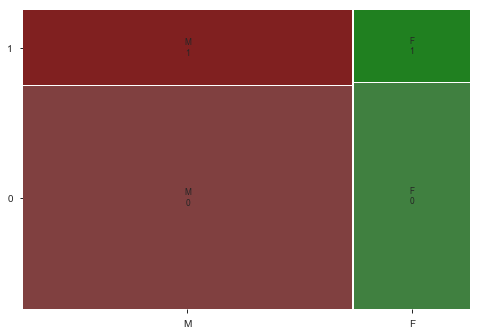

In [16]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df,["gender","status"])
plt.show()

In [118]:
def crosstab_multi (x,y) : 
    print (pd.crosstab(x,y),"\n\n",pd.crosstab(x,y,normalize="index"),"\n\n",pd.crosstab(x,y,normalize="columns"))

In [119]:
crosstab_multi (df["status"],df['gender'])

gender    F    M
status          
0       136  380
1        43  127 

 gender         F         M
status                    
0       0.263566  0.736434
1       0.252941  0.747059 

 gender         F         M
status                    
0       0.759777  0.749507
1       0.240223  0.250493


In [29]:
from scipy import stats
df.columns

Index(['e_code', 'status', 'hire_date', 'service_agreement', 'job_level',
       'performance_rating_2018', 'performance_rating_2017', 'year_of_birth',
       'gender', 'distance_from_home', 'manager_changes', 'no_of_promotions',
       'risk_of_attrition', 'potential_rating', 'bonus', 'no_courses_taken',
       'time_in_position', 'awards', 'signon', 'manager_sat', 'employee_sat',
       'salary_2017', 'salary_2018', 'var_rating', 'percentage_salary_change',
       'age'],
      dtype='object')

In [132]:
# 카이 제곱 검정을 빠르게 하도록 함수 설정
def chi_multi (x, y) :
    for i in x : #카이제곱 검정을 실시하여 p-Value 추출
        y = y
        table = pd.crosstab(df[ i ], y)
        chi_table = stats.chi2_contingency(table)
        if chi_table[1] > 0.005 :  #p-value 값이 귀무가설을 기각하는 지 검증하여 프린트
            pass
        else : 
            print ("귀무가설 기각 / p-value between",i ,"and", y.name," : ", chi_table[1])

In [145]:
chi_multi (list(df.columns.values), df["status"])

귀무가설 기각 / p-value between status and status  :  4.8361514559412625e-150
귀무가설 기각 / p-value between risk_of_attrition and status  :  3.944526151206098e-12
귀무가설 기각 / p-value between potential_rating and status  :  2.019545165087339e-05
귀무가설 기각 / p-value between no_courses_taken and status  :  3.911152449060662e-21
귀무가설 기각 / p-value between time_in_position and status  :  4.888814410957131e-05
귀무가설 기각 / p-value between awards and status  :  0.000875372103862832
귀무가설 기각 / p-value between manager_sat and status  :  3.8376510266153956e-63
귀무가설 기각 / p-value between employee_sat and status  :  2.053734365905802e-13
귀무가설 기각 / p-value between salary_2017 and status  :  9.98138206971157e-06
귀무가설 기각 / p-value between var_rating and status  :  0.0035318724704160947


In [157]:
stats.ttest_rel(df["employee_sat"],df["status"])


Ttest_relResult(statistic=416.9441625176915, pvalue=0.0)